In [8]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
from preProcessing import preProcessor

# Final Project - Matan Mizrachi , Moshiko Maymon
In our project we decided to implement a sudoku solver; given a picture of a sudoku puzzle our code recognizes the given board, run a sudoku solver algorithm using backtracking, and print the result ontop of the sudoku picture.
We will show the outline of the algorithm, starting at the pre-process procedure up to the end result where we have the result displayed on the picture.

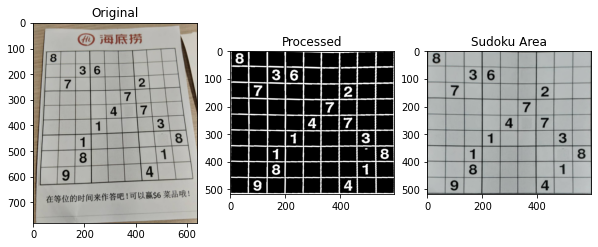

In [9]:
img = cv2.imread('data/Example24.png')
preprocess = preProcessor(img)
sudoku = preprocess.gray_area

img = img[:,:,::-1]

fig =plt.figure(figsize=(10, 16))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Original')
ax1.imshow(img)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Processed')
ax2.imshow(sudoku, cmap='gray')
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Sudoku Area')
ax3.imshow(preprocess.original_area)

In the above code block we used our class preProcessor implemented in preProcessing.py to run bunch of algorithms on the original image to extract the relevant board.


The pre-processing pipeline is as follows:
- Turn the image to gray scale
- Run Gaussian blur filter on the image.
- De-noising algorithm to get rid of noise in the picture.
- Adaptive threshold.

The relevant snippet of code in our project:
```
imag = cv2.GaussianBlur(imag, (5, 5), 0)
imag = cv2.fastNlMeansDenoising(imag, None)
imag = cv2.adaptiveThreshold(imag, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
```

From here we proceed to identify outlines in the picture to identify the board and locate cells and thus the relevant areas to identify digits in later on. This procedure is implemented in SodukoSolver.py in class Cells. 

We run Canny Edge detectors and Hough Line transform to identify the grid of lines in the sudoku board:
```
edges = cv2.Canny(sudGrid, 30, 90, 3)
lines = cv2.HoughLinesP(sudGrid, 1, np.pi / 40, 180, maxLineGap=250, minLineLength=60, lines=edges)
```

It shall be noted we use in our code the two types of transformation; either the deterministic one or the probablistic one depending on the grid.

Cells detected.


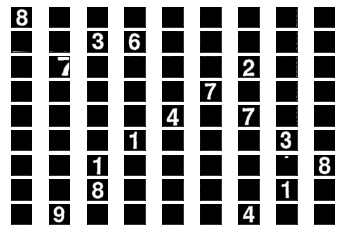

In [10]:
from SudokuSolver import Cells

cells = Cells(img)
cells.plot()

Now that we have the sudoku board grid mapped and identified we are left to reocgnize the digits in the relevant cells.
To do so we are using a linear SVM model, trained on a dataset of digits we found, to recognize the digits in the board:
```
self.svm = cv2.ml.SVM_create()
self.svm.setType(cv2.ml.SVM_C_SVC)
self.svm.setKernel(cv2.ml.SVM_LINEAR)

self.digits_dataset = cv2.imread('Dataset/set.jpg', 0)
self.digits_dataset: np.ndarray = np.array([np.hsplit(row, 9) for
                                            row in np.vsplit(self.digits_dataset, 40)]).reshape(-1, 2500)

self.digits_dataset: np.ndarray = self.digits_dataset.reshape((360, 50, 50))
```

In [11]:
from SudokuSolver import Digits

digits = Digits(img)
grid = digits.matrix.copy() 
# Now we have the soduko board identified and is in grid variable.
print(grid)

Cells detected.
Training Model...
Done training!
[[8. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 6. 0. 0. 0. 0. 0.]
 [0. 7. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 7. 0. 0. 0.]
 [0. 0. 0. 0. 4. 0. 7. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 3. 0.]
 [0. 0. 1. 0. 0. 0. 0. 7. 8.]
 [0. 0. 8. 0. 0. 0. 0. 1. 0.]
 [0. 9. 0. 0. 0. 0. 4. 0. 0.]]


Now we have the puzzle in grid variable and all left to do is solve it. We do so by using the known backtracking approach as can be seen in the next block of code.

In [12]:
def findNextCellToFill(grid1, i, j):
    for x in range(i, 9):
        for y in range(j, 9):
            if grid1[x][y] == 0:
                return x, y
            for x in range(0, 9):
                for y in range(0, 9):
                    if grid1[x][y] == 0:
                        return x, y
    return -1, -1

def isValid(grid1, i, j, e):
    rowOk = all([e != grid1[i][x] for x in range(9)])
    if rowOk:
        columnOk = all([e != grid1[x][j] for x in range(9)])
        if columnOk:
        # finding the top left x,y co-ordinates of the section containing the i,j cell
          secTopX, secTopY = 3 * (i // 3), 3 * (j // 3)  # floored quotient should be used here.
          for x in range(secTopX, secTopX + 3):
              for y in range(secTopY, secTopY + 3):
                if grid1[x][y] == e:
                    return False
          return True
    return False

def solveSudoku(grid1, i=0, j=0):
    i, j = findNextCellToFill(grid1, i, j)
    if i == -1:
        return True
    for e in range(1, 10):
        if isValid(grid1, i, j, e):
            grid1[i][j] = e
            if solveSudoku(grid1, i, j):
                return True
                # Undo the current cell for backtracking
            grid1[i][j] = 0
    return False

In [13]:
%%capture
solveSudoku(grid)

So we solved by now the sudoku puzzle and all left to do is print the solution on the picture. We iterate over the cells identified in the original cell and if the corresponding entry in the given grid is zero we draw it inside the relevant slice of the picture using cv2:

```
to_draw: np.ndarray = self.digits.cells.original.copy()
mat = self.digits.matrix.flatten()
sol = self.solution.flatten()

def drawDigit(cell: np.ndarray, digit: int, color: tuple):
    h, w, _ = cell.shape

    size = w / h
    offsetTop = int(h * 0.75 * size)
    offsetLeft = int(w * 0.25 * size)

    font = cv2.FONT_HERSHEY_SIMPLEX
    return cv2.putText(cell.copy(), str(int(digit)), (offsetLeft, offsetTop), font, size, color, 2, cv2.LINE_AA)

for i in range(81):
    if self.digits.matrix.flatten()[i] == 0:
        to_draw[i][0] = drawDigit(to_draw[i][0], sol[i], (170, 50, 150))

return to_draw
```

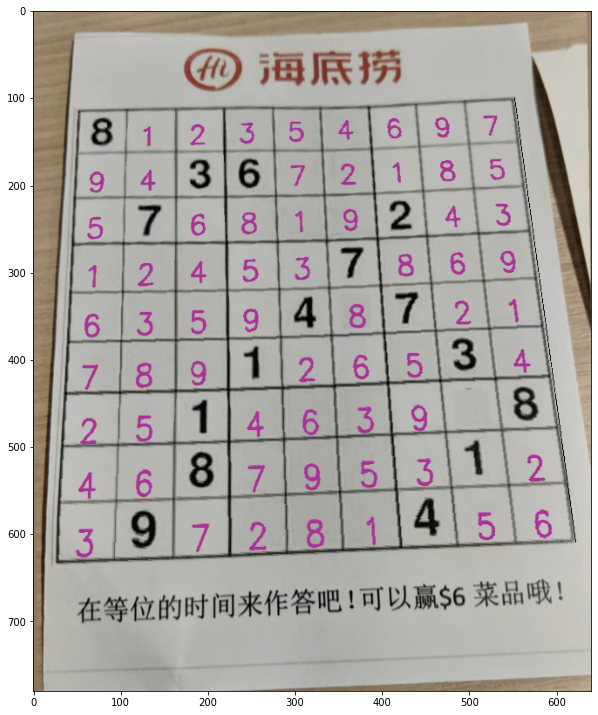

In [14]:
from SudokuSolver import Sudoku
plt.figure(figsize=(10, 16))
k1 = Sudoku.drawSolution(grid, cells.original, digits.matrix)
k1 = k1[:, 0]
k1 = Sudoku.cells_to_grid(k1, cells.prep.original_area)

plt.imshow(cv2.warpPerspective(k1, cells.prep.original_M,
                                             (cells.prep.image.shape[1],
                                              cells.prep.image.shape[0]),
                                             dst=cells.prep.image, borderMode=cv2.BORDER_TRANSPARENT,
                                             flags=cv2.WARP_INVERSE_MAP))

For video creation and live solving, check out the ExtraFeatures.py file.